This notebook is based on summary from Fernando Torres </br>
https://www.kaggle.com/code/lusfernandotorres/transformer-from-scratch-with-pytorch </br>
Most of the code and comments are copied from the article and there is only added extension with more explanation where is needed. 

## Lib imports

In [15]:
# Importing libraries

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

# Math
import math

# HuggingFace libraries
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

import numpy as np

import matplotlib.pyplot as plt

# Pathlib
from pathlib import Path

# typing
from typing import Any

# Library for progress bars in loops
from tqdm import tqdm

# Importing library of warnings
import warnings

## Config definition

In the following cell, we will define two functions to configure our model and the training process.

In the get_config function, we define crucial parameters for the training process. batch_size for the number of training examples used in one iteration, num_epochs as the number of times the entire dataset is passed forward and backward through the Transformer, lr as the learning rate for the optimizer, etc. We will also finally define the pairs from the OpusBook dataset, 'lang_src': 'en' for selecting English as the source language and 'lang_tgt': 'it' for selecting Italian as the target language.

In [16]:
# Define settings for building and training the transformer model
def get_config():
    return {
        "batch_size": 8,
        "num_epochs": 20,
        "lr": 10**-4,
        "seq_len": 350,
        "d_model": 512,  # Dimensions of the embeddings in the Transformer. 512 like in the "Attention Is All You Need" paper.
        "lang_src": "en",
        "lang_tgt": "it",
        "model_folder": "weights",
        "model_basename": "tmodel_",
        "preload": None,
        "tokenizer_file": "tokenizer_{0}.json",
        "experiment_name": "runs/tmodel",
    }

## Dataset

Lets start with our goal definition. We have a dataset on with paris of sentences in different languages. We want to train a model, so we will be able to take input and translate it into same meaning, but in different language.



For this task, we will use the OpusBooks dataset, available on 🤗Hugging Face. This dataset consists of two features, id and translation. The translation feature contains pairs of sentences in different languages, such as Spanish and Portuguese, English and French, and so forth.

I first tried translating sentences from English to Portuguese—my native tongue — but there are only 1.4k examples for this pair, so the results were not satisfying in the current configurations for this model. I then tried to use the English-French pair due to its higher number of examples—127k—but it would take too long to train with the current configurations. I then opted to train the model on the English-Italian pair, the same one used in the Coding a Transformer from scratch on PyTorch, with full explanation, training and inference video, as that was a good balance between performance and time of training.

We start by defining the get_all_sentences function to iterate over the dataset and extract the sentences according to the language pair defined—we will do that later.


Lets start by looking at the dataset

In [17]:
config = get_config()
ds_raw = load_dataset("opus_books", f'{config["lang_src"]}-{config["lang_tgt"]}', split="train")
print(f"ds_raw {ds_raw}")

ds_raw Dataset({
    features: ['id', 'translation'],
    num_rows: 32332
})


We can see, that dataset has 32 332 rows/record. Lets have a look at one record in detail. It consists out of 'Source' and 'translation'

In [18]:
ds_raw[0]["translation"].keys()

dict_keys(['en', 'it'])

In [19]:
print(f"Keys in one record: {ds_raw[0].keys()}")
print(f"Keys in 'translation': {ds_raw[0]['translation'].keys()}")
print(f"Complete dictionary: {ds_raw[0]}")

Keys in one record: dict_keys(['id', 'translation'])
Keys in 'translation': dict_keys(['en', 'it'])
Complete dictionary: {'id': '0', 'translation': {'en': 'Source: Project Gutenberg', 'it': 'Source: www.liberliber.it/Audiobook available here'}}


## Tokenizer

Now, that we know how dataset looks like, lets move on to tokenizer. 

Tokenization is a crucial preprocessing step for our Transformer model. In this step, we convert raw text into a number format that the model can process.

There are several Tokenization strategies. We will use the word-level tokenization to transform each word in a sentence into a token.

<a><img src="https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F8d5e749c-b0bd-4496-85a1-9b4397ad935f_1400x787.jpeg" ></a>

Different tokenization strategies. Source: shaankhosla.substack.com.

After tokenizing a sentence, we map each token to an unique integer ID based on the created vocabulary present in the training corpus during the training of the tokenizer. Each integer number represents a specific word in the vocabulary.

Besides the words in the training corpus, Transformers use special tokens for specific purposes. These are some that we will define right away:

• [UNK]: This token is used to identify an unknown word in the sequence.

• [PAD]: Padding token to ensure that all sequences in a batch have the same length, so we pad shorter sentences with this token. We use attention masks to "tell" the model to ignore the padded tokens during training since they don't have any real meaning to the task.

• [SOS]: This is a token used to signal the Start of Sentence.

• [EOS]: This is a token used to signal the End of Sentence.

In the build_tokenizer function below, we ensure a tokenizer is ready to train the model. It checks if there is an existing tokenizer, and if that is not the case, it trains a new tokenizer.


We start by defining the get_all_sentences function to iterate over the dataset and extract the sentences according to the language pair defined—we will do that later.

In [20]:
# Iterating through dataset to extract the original sentence and its translation
def get_all_sentences(ds, lang):
    for pair in ds:
        yield pair["translation"][lang]

We define function, that is going to build us a tokenizer.It basicaly learn how to translate all words in text into integer. 

In [21]:
# Defining Tokenizer
def build_tokenizer(config, ds, lang):

    # Crating a file path for the tokenizer
    tokenizer_path = Path(config["tokenizer_file"].format(lang))

    # Checking if Tokenizer already exists
    if not Path.exists(tokenizer_path):

        # If it doesn't exist, we create a new one
        tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))  # Initializing a new world-level tokenizer
        tokenizer.pre_tokenizer = Whitespace()  # We will split the text into tokens based on whitespace

        # Creating a trainer for the new tokenizer
        trainer = WordLevelTrainer(
            special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"], min_frequency=2
        )  # Defining Word Level strategy and special tokens

        # Training new tokenizer on sentences from the dataset and language specified
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)
        tokenizer.save(
            str(tokenizer_path)
        )  # Saving trained tokenizer to the file path specified at the beginning of the function
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))  # If the tokenizer already exist, we load it
    return tokenizer  # Returns the loaded tokenizer or the trained tokenizer

Call function of tokenizer, so we can use it in our examples later and select firs par of sentences from our dataset.

In [22]:
# Building or loading tokenizer for both the source and target languages 
tokenizer_src = build_tokenizer(config, ds_raw, config['lang_src'])
tokenizer_tgt = build_tokenizer(config, ds_raw, config['lang_tgt'])
pair = ds_raw[0]

Lets look at example. We have our source example as pure text. We tokenize it by splitting word into tokend and then converting them into integers. Integers stands for IDs of particular words. e.g. word "Hello" will be replace by for example ID/integer 451. 

In [23]:
print(f"Original text: {pair['translation'][config['lang_src']]}")
print(f"Tokens from text {tokenizer_src.encode(pair['translation'][config['lang_src']]).tokens}")
print(f"Token Ids for each token {tokenizer_src.encode(pair['translation'][config['lang_src']]).ids}")

Original text: Source: Project Gutenberg
Tokens from text ['Source', ':', 'Project', '[UNK]']
Token Ids for each token [5781, 38, 7699, 0]


## Input Embeddings

Now, when we have token and tokens converted into vectors, lets move on to embeddings. 



When we observe the Transformer architecture image above, we can see that the Embeddings represent the first step of both blocks.

The InputEmbedding class below is responsible for converting the input text into numerical vectors of d_model dimensions. To prevent that our input embeddings become extremely small, we normalize them by multiplying them by the √dmodel.


In the image below, we can see how the embeddings are created. First, we have a sentence that gets split into tokens—we will explore what tokens are later on—. Then, the token IDs—identification numbers—are transformed into the embeddings, which are high-dimensional vectors.

In [24]:
# Creating Input Embeddings
class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model  # Dimension of vectors (512)
        self.vocab_size = vocab_size  # Size of the vocabulary
        self.embedding = nn.Embedding(
            vocab_size, d_model
        )  # PyTorch layer that converts integer indices to dense embeddings

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)  # Normalizing the variance of the embeddings

Firstly convert teext again into ids of tokens. Get vocabulary size of our tokenizer, which is needed for our Embeddings and then convert ids into Embeddings. Embeddings are vector space representation of particular word. 

In [25]:
# Get words IDs
src_ids = tokenizer_src.encode(pair["translation"][config["lang_src"]]).ids
# Get vocab size
src_vocab_size = tokenizer_src.get_vocab_size()
# Initialize Embeddings using vocab size
src_embedd = InputEmbeddings(d_model=config["d_model"], vocab_size=src_vocab_size)
# Create embeddings
embedding = src_embedd.forward(torch.tensor(src_ids))
print(f"Shape of embedding is: {embedding.shape} \n")
print(embedding)

Shape of embedding is: torch.Size([4, 512]) 

tensor([[-30.2049,  12.0441,   6.7643,  ...,  -8.0979, -39.1493,  29.3768],
        [-24.0882,  -5.0380, -33.1334,  ..., -34.1188, -16.1505,  18.6439],
        [-15.4464,  21.8942,   3.9686,  ...,  -9.2410,   4.4873,   4.4072],
        [-19.8690, -19.4484, -29.5398,  ...,  24.3943, -14.7542,  -7.6271]],
       grad_fn=<MulBackward0>)


In [26]:
src_embedd.forward(torch.tensor(src_ids)).shape

torch.Size([4, 512])

## Loading Dataset



For this task, we will use the OpusBooks dataset, available on 🤗Hugging Face. This dataset consists of two features, id and translation. The translation feature contains pairs of sentences in different languages, such as Spanish and Portuguese, English and French, and so forth.

I first tried translating sentences from English to Portuguese—my native tongue — but there are only 1.4k examples for this pair, so the results were not satisfying in the current configurations for this model. I then tried to use the English-French pair due to its higher number of examples—127k—but it would take too long to train with the current configurations. I then opted to train the model on the English-Italian pair, the same one used in the Coding a Transformer from scratch on PyTorch, with full explanation, training and inference video, as that was a good balance between performance and time of training.

We start by defining the get_all_sentences function to iterate over the dataset and extract the sentences according to the language pair defined—we will do that later.


First thing we need to do is define mask, which will filter out words, therefore decoded mask wont be displaying future words.

In [34]:
def casual_mask(size):
    # Creating a square matrix of dimensions 'size x size' filled with ones
    mask = torch.triu(torch.ones(1, size, size), diagonal=1).type(torch.int)
    return mask == 0

In [36]:
casual_mask(4)

tensor([[[ True, False, False, False],
         [ True,  True, False, False],
         [ True,  True,  True, False],
         [ True,  True,  True,  True]]])

We can now define standard dataset. Method __getitem__ is fairly simple. Based on index we take source and target sentences. We convert them into ids. We add padding tokens to fill maximum length of source and target.

In [33]:
class BilingualDataset(Dataset):

    # This takes in the dataset contaning sentence pairs, the tokenizers for target and source languages, and the strings of source and target languages
    # 'seq_len' defines the sequence length for both languages
    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len) -> None:
        super().__init__()

        self.seq_len = seq_len
        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        # Defining special tokens by using the target language tokenizer
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

    # Total number of instances in the dataset (some pairs are larger than others)
    def __len__(self):
        return len(self.ds)

    # Using the index to retrive source and target texts
    def __getitem__(self, index: Any) -> Any:
        src_target_pair = self.ds[index]
        src_text = src_target_pair["translation"][self.src_lang]
        tgt_text = src_target_pair["translation"][self.tgt_lang]

        # Tokenizing source and target texts
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Computing how many padding tokens need to be added to the tokenized texts
        # Source tokens
        enc_num_padding_tokens = (
            self.seq_len - len(enc_input_tokens) - 2
        )  # Subtracting the two '[EOS]' and '[SOS]' special tokens
        # Target tokens
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1  # Subtracting the '[SOS]' special token

        # If the texts exceed the 'seq_len' allowed, it will raise an error. This means that one of the sentences in the pair is too long to be processed
        # given the current sequence length limit (this will be defined in the config dictionary below)
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError("Sentence is too long")

        # Building the encoder input tensor by combining several elements
        encoder_input = torch.cat(
            [
                self.sos_token,  # inserting the '[SOS]' token
                torch.tensor(enc_input_tokens, dtype=torch.int64),  # Inserting the tokenized source text
                self.eos_token,  # Inserting the '[EOS]' token
                torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype=torch.int64),  # Addind padding tokens
            ]
        )

        # Building the decoder input tensor by combining several elements
        decoder_input = torch.cat(
            [
                self.sos_token,  # inserting the '[SOS]' token
                torch.tensor(dec_input_tokens, dtype=torch.int64),  # Inserting the tokenized target text
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),  # Addind padding tokens
            ]
        )

        # Creating a label tensor, the expected output for training the model
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype=torch.int64),  # Inserting the tokenized target text
                self.eos_token,  # Inserting the '[EOS]' token
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),  # Adding padding tokens
            ]
        )

        # Ensuring that the length of each tensor above is equal to the defined 'seq_len'
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            "encoder_input": encoder_input,
            "decoder_input": decoder_input,
            "encoder_mask": (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),
            "decoder_mask": (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int()
            & casual_mask(decoder_input.size(0)),
            "label": label,
            "src_text": src_text,
            "tgt_text": tgt_text,
        }

Lets see returned keys

In [56]:
ds_raw = load_dataset("opus_books", f'{config["lang_src"]}-{config["lang_tgt"]}', split="train")
BDS = BilingualDataset(ds_raw, 
                 tokenizer_src, 
                 tokenizer_tgt, 
                 config["lang_src"], 
                 config["lang_tgt"], 
                 config["seq_len"])
BDS.__getitem__(0).keys()

dict_keys(['encoder_input', 'decoder_input', 'encoder_mask', 'decoder_mask', 'label', 'src_text', 'tgt_text'])

We can build dataloaders right now. 



The get_dl function is defined to load and prepare the dataset for training and validation. In this function, we build or load the tokenizer, split the dataset, and create DataLoaders, so the model can successfully iterate over the dataset in batches. The result of these functions is tokenizers for the source and target languages plus the DataLoader objects.


In [57]:
def get_dl(config):

    # Loading the train portion of the OpusBooks dataset.
    # The Language pairs will be defined in the 'config' dictionary we will build later
    ds_raw = load_dataset("opus_books", f'{config["lang_src"]}-{config["lang_tgt"]}', split="train")

    # Building or loading tokenizer for both the source and target languages
    tokenizer_src = build_tokenizer(config, ds_raw, config["lang_src"])
    tokenizer_tgt = build_tokenizer(config, ds_raw, config["lang_tgt"])

    # Splitting the dataset for training and validation
    train_ds_size = int(0.9 * len(ds_raw))  # 90% for training
    val_ds_size = len(ds_raw) - train_ds_size  # 10% for validation
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size])  # Randomly splitting the dataset

    # Processing data with the BilingualDataset class, which we will define below
    train_ds = BilingualDataset(
        train_ds_raw, tokenizer_src, tokenizer_tgt, config["lang_src"], config["lang_tgt"], config["seq_len"]
    )
    val_ds = BilingualDataset(
        val_ds_raw, tokenizer_src, tokenizer_tgt, config["lang_src"], config["lang_tgt"], config["seq_len"]
    )

    # Iterating over the entire dataset and printing the maximum length found in the sentences of both the source and target languages
    max_len_src = 0
    max_len_tgt = 0
    for pair in ds_raw:
        src_ids = tokenizer_src.encode(pair["translation"][config["lang_src"]]).ids
        tgt_ids = tokenizer_src.encode(pair["translation"][config["lang_tgt"]]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f"Max length of source sentence: {max_len_src}")
    print(f"Max length of target sentence: {max_len_tgt}")

    # Creating dataloaders for the training and validadion sets
    # Dataloaders are used to iterate over the dataset in batches during training and validation
    train_dataloader = DataLoader(
        train_ds, batch_size=config["batch_size"], shuffle=True
    )  # Batch size will be defined in the config dictionary
    val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)

    return (
        train_dataloader,
        val_dataloader,
        tokenizer_src,
        tokenizer_tgt,
    )  # Returning the DataLoader objects and tokenizers

## Transformers Introduction



In 2017, the Google Research team published a paper called "Attention Is All You Need", which presented the Transformer architecture and was a paradigm shift in Machine Learning, especially in Deep Learning and the field of natural language processing.

The Transformer, with its parallel processing capabilities, allowed for more efficient and scalable models, making it easier to train them on large datasets. It also demonstrated superior performance in several NLP tasks, such as sentiment analysis and text generation tasks.

The archicture presented in this paper served as the foundation for subsequent models like GPT and BERT. Besides NLP, the Transformer architecture is used in other fields, like audio processing and computer vision. You can see the usage of Transformers in audio classification in the notebook Audio Data: Music Genre Classification.

Even though you can easily employ different types of Transformers with the 🤗Transformers library, it is crucial to understand how things truly work by building them from scratch.

In this notebook, we will explore the Transformer architecture and all its components. I will use PyTorch to build all the necessary structures and blocks, and I will use the Coding a Transformer from scratch on PyTorch, with full explanation, training and inference video posted by Umar Jamil on YouTube as reference.

## Transformer architecture

<a ><img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*s5XcjuosS8ohfsW5xFT3sQ.png"></a>

Source: Attention Is All You Need

The Transformer architecture has two main blocks: the encoder and the decoder. Let's take a look at them further.

<b>Encoder</b>: It has a Multi-Head Attention mechanism and a fully connected Feed-Forward network. There are also residual connections around the two sub-layers, plus layer normalization for the output of each sub-layer. All sub-layers in the model and the embedding layers produce outputs of dimension dmodel=512

.

<b>Decoder</b>: The decoder follows a similar structure, but it inserts a third sub-layer that performs multi-head attention over the output of the encoder block. There is also a modification of the self-attention sub-layer in the decoder block to avoid positions from attending to subsequent positions. This masking ensures that the predictions for position i
depend solely on the known outputs at positions less than i

.

Both the encoder and decode blocks are repeated N
times. In the original paper, they defined N=6, and we will define a similar value in this notebook.

## Positional Encoding



In the original paper, the authors add the positional encodings to the input embeddings at the bottom of both the encoder and decoder blocks so the model can have some information about the relative or absolute position of the tokens in the sequence. The positional encodings have the same dimension dmodel

as the embeddings, so that the two vectors can be summed and we can combine the semantic content from the word embeddings and positional information from the positional encodings.

In the PositionalEncoding class below, we will create a matrix of positional encodings pe with dimensions (seq_len, d_model). We will start by filling it with 0

s.We will then apply the sine function to even indices of the positional encoding matrix while the cosine function is applied to the odd ones.

Even Indices (2i):PE(pos, 2i)=sin(pos100002i/dmodel)(1)

Odd Indices (2i+1):PE(pos, 2i+1)=cos(pos100002i/dmodel)(2)

We apply the sine and cosine functions because it allows the model to determine the position of a word based on the position of other words in the sequence, since for any fixed offset k
, PEpos+k can be represented as a linear function of PEpos. This happens due to the properties of sine and cosine functions, where a shift in the input results in a predictable change in the output.

In [58]:
# Creating the Positional Encoding
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model  # Dimensionality of the model
        self.seq_len = seq_len  # Maximum sequence length
        self.dropout = nn.Dropout(dropout)  # Dropout layer to prevent overfitting

        # Creating a positional encoding matrix of shape (seq_len, d_model) filled with zeros
        pe = torch.zeros(seq_len, d_model)

        # Creating a tensor representing positions (0 to seq_len - 1)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(
            1
        )  # Transforming 'position' into a 2D tensor['seq_len, 1']

        # Creating the division term for the positional encoding formula
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices in pe
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices in pe
        pe[:, 1::2] = torch.cos(position * div_term)

        # Adding an extra dimension at the beginning of pe matrix for batch handling
        pe = pe.unsqueeze(0)

        # Registering 'pe' as buffer. Buffer is a tensor not considered as a model parameter
        self.register_buffer("pe", pe)

    def forward(self, x):
        # Addind positional encoding to the input tensor X
        x = x + (self.pe[:, : x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)  # Dropout for regularization

Lets visualize how such positional encoding can look like using sin/cos. 

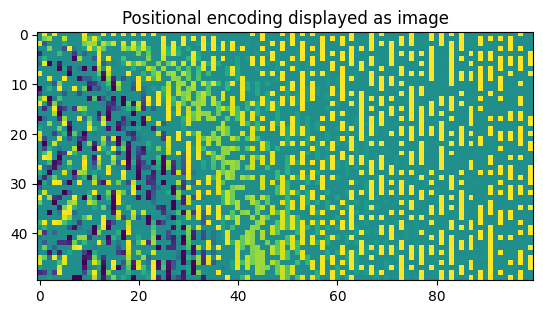

In [59]:
PE = PositionalEncoding(d_model=100,seq_len=50,dropout=0.5)
positional_encoding = PE.forward(torch.tensor(np.zeros((1, 50, 100))))
positional_encoding = torch.squeeze(positional_encoding)

plt.figure()
plt.imshow(positional_encoding)
plt.title("Positional encoding displayed as image")
plt.show()

## Layer normalization



When we look at the encoder and decoder blocks, we see several normalization layers called Add & Norm.

The LayerNormalization class below performs layer normalization on the input data. During its forward pass, we compute the mean and standard deviation of the input data. We then normalize the input data by subtracting the mean and dividing by the standard deviation plus a small number called epsilon to avoid any divisions by zero. This process results in a normalized output with a mean 0 and a standard deviation 1.

We will then scale the normalized output by a learnable parameter alpha and add a learnable parameter called bias. The training process is responsible for adjusting these parameters. The final result is a layer-normalized tensor, which ensures that the scale of the inputs to layers in the network is consistent.


In [60]:
# Creating Layer Normalization
class LayerNormalization(nn.Module):

    def __init__(self, eps: float = 10**-6) -> None:  # We define epsilon as 0.000001 to avoid division by zero
        super().__init__()
        self.eps = eps

        # We define alpha as a trainable parameter and initialize it with ones
        self.alpha = nn.Parameter(torch.ones(1))  # One-dimensional tensor that will be used to scale the input data

        # We define bias as a trainable parameter and initialize it with zeros
        self.bias = nn.Parameter(torch.zeros(1))  # One-dimensional tenso that will be added to the input data

    def forward(self, x):
        mean = x.mean(
            dim=-1, keepdim=True
        )  # Computing the mean of the input data. Keeping the number of dimensions unchanged
        std = x.std(
            dim=-1, keepdim=True
        )  # Computing the standard deviation of the input data. Keeping the number of dimensions unchanged

        # Returning the normalized input
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

Lets see example of normalization

In [62]:
LN = LayerNormalization()
LN.forward(torch.tensor([999., -999., 15., -15.]))

tensor([ 1.2246, -1.2246,  0.0184, -0.0184], grad_fn=<AddBackward0>)

## Feed-Forward network



In the fully connected feed-forward network, we apply two linear transformations with a ReLU activation in between. We can mathematically represent this operation as:

FFN(x)=max(0,xW1+b1)W2+b2(3)

W1
and W2 are the weights, while b1 and b2

are the biases of the two linear transformations.

In the FeedForwardBlock below, we will define the two linear transformations—self.linear_1 and self.linear_2—and the inner-layer d_ff. The input data will first pass through the self.linear_1 transformation, which increases its dimensionality from d_model to d_ff. The output of this operation passes through the ReLU activation function, which introduces non-linearity so the network can learn more complex patterns, and the self.dropout layer is applied to mitigate overfitting. The final operation is the self.linear_2 transformation to the dropout-modified tensor, which transforms it back to the original d_model dimension.

In [63]:
# Creating Feed Forward Layers
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        # First linear transformation
        self.linear_1 = nn.Linear(d_model, d_ff)  # W1 & b1
        self.dropout = nn.Dropout(dropout)  # Dropout to prevent overfitting
        # Second linear transformation
        self.linear_2 = nn.Linear(d_ff, d_model)  # W2 & b2

    def forward(self, x):
        # (Batch, seq_len, d_model) --> (batch, seq_len, d_ff) -->(batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

Multi-Head attention

The Multi-Head Attention is the most crucial component of the Transformer. It is responsible for helping the model to understand complex relationships and patterns in the data.

The image below displays how the Multi-Head Attention works. It doesn't include batch dimension because it only illustrates the process for one single sentence.

<a href="multi_head_attention.asp"><img src="https://i.imgur.com/JqJVrsj.png"></a>

Source: YouTube: Coding a Transformer from scratch on PyTorch, with full explanation, training and inference by Umar Jamil.

The Multi-Head Attention block receives the input data split into queries, keys, and values organized into matrices Q
, K, and V

. Each matrix contains different facets of the input, and they have the same dimensions as the input.

We then linearly transform each matrix by their respective weight matrices WQ
, WK, and WV. These transformations will result in new matrices Q′, K′, and V′, which will be split into smaller matrices corresponding to different heads h

, allowing the model to attend to information from different representation subspaces in parallel. This split creates multiple sets of queries, keys, and values for each head.

Finally, we concatenate every head into an H
matrix, which is then transformed by another weight matrix Wo to produce the multi-head attention output, a matrix MH−A that retains the input dimensionality.

In [64]:
# Creating the Multi-Head Attention block
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:  # h = number of heads
        super().__init__()
        self.d_model = d_model
        self.h = h

        # We ensure that the dimensions of the model is divisible by the number of heads
        assert d_model % h == 0, "d_model is not divisible by h"

        # d_k is the dimension of each attention head's key, query, and value vectors
        self.d_k = d_model // h  # d_k formula, like in the original "Attention Is All You Need" paper

        # Defining the weight matrices
        self.w_q = nn.Linear(d_model, d_model)  # W_q
        self.w_k = nn.Linear(d_model, d_model)  # W_k
        self.w_v = nn.Linear(d_model, d_model)  # W_v
        self.w_o = nn.Linear(d_model, d_model)  # W_o

        self.dropout = nn.Dropout(dropout)  # Dropout layer to avoid overfitting

    @staticmethod
    def attention(
        query, key, value, mask, dropout: nn.Dropout
    ):  # mask => When we want certain words to NOT interact with others, we "hide" them

        d_k = query.shape[-1]  # The last dimension of query, key, and value

        # We calculate the Attention(Q,K,V) as in the formula in the image above
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(
            d_k
        )  # @ = Matrix multiplication sign in PyTorch

        # Before applying the softmax, we apply the mask to hide some interactions between words
        if mask is not None:  # If a mask IS defined...
            attention_scores.masked_fill_(mask == 0, -1e9)  # Replace each value where mask is equal to 0 by -1e9
        attention_scores = attention_scores.softmax(dim=-1)  # Applying softmax
        if dropout is not None:  # If a dropout IS defined...
            attention_scores = dropout(attention_scores)  # We apply dropout to prevent overfitting

        return (
            attention_scores @ value
        ), attention_scores  # Multiply the output matrix by the V matrix, as in the formula

    def forward(self, q, k, v, mask):

        query = self.w_q(q)  # Q' matrix
        key = self.w_k(k)  # K' matrix
        value = self.w_v(v)  # V' matrix

        # Splitting results into smaller matrices for the different heads
        # Splitting embeddings (third dimension) into h parts
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(
            1, 2
        )  # Transpose => bring the head to the second dimension
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(
            1, 2
        )  # Transpose => bring the head to the second dimension
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(
            1, 2
        )  # Transpose => bring the head to the second dimension

        # Obtaining the output and the attention scores
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        # Obtaining the H matrix
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        return self.w_o(x)  # Multiply the H matrix by the weight matrix W_o, resulting in the MH-A matrix

## Residual connection



When we look at the architecture of the Transformer, we see that each sub-layer, including the self-attention and Feed Forward blocks, adds its output to its input before passing it to the Add & Norm layer. This approach integrates the output with the original input in the Add & Norm layer. This process is known as the skip connection, which allows the Transformer to train deep networks more effectively by providing a shortcut for the gradient to flow through during backpropagation.

The ResidualConnection class below is responsible for this process.


In [12]:
# Building Residual Connection
class ResidualConnection(nn.Module):
    def __init__(self, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)  # We use a dropout layer to prevent overfitting
        self.norm = LayerNormalization()  # We use a normalization layer

    def forward(self, x, sublayer):
        # We normalize the input and add it to the original input 'x'. This creates the residual connection process.
        return x + self.dropout(sublayer(self.norm(x)))

## Encoder

We will now build the encoder. We create the EncoderBlock class, consisting of the Multi-Head Attention and Feed Forward layers, plus the residual connections.

<a href="Encoder"><img src="https://www.researchgate.net/profile/Ehsan-Amjadian/publication/352239001/figure/fig1/AS:1033334390013952@1623377525434/Detailed-view-of-a-transformer-encoder-block-It-first-passes-the-input-through-an.jpg"></a>



In the original paper, the Encoder Block repeats six times. We create the Encoder class as an assembly of multiple EncoderBlocks. We also add layer normalization as a final step after processing the input through all its blocks.


In [ ]:
# Building Encoder Block
class EncoderBlock(nn.Module):

    # This block takes in the MultiHeadAttentionBlock and FeedForwardBlock, as well as the dropout rate for the residual connections
    def __init__(
        self, self_attention_block: MultiHeadAttentionBlock, 
        feed_forward_block: FeedForwardBlock, 
        dropout: float
    ) -> None:
        super().__init__()
        # Storing the self-attention block and feed-forward block
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList(
            [ResidualConnection(dropout) for _ in range(2)]
        )  # 2 Residual Connections with dropout

    def forward(self, x, src_mask):
        # Applying the first residual connection with the self-attention block
        x = self.residual_connections[0](
            x, lambda x: self.self_attention_block(x, x, x, src_mask)
        )  # Three 'x's corresponding to query, key, and value inputs plus source mask

        # Applying the second residual connection with the feed-forward block
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x  # Output tensor after applying self-attention and feed-forward layers with residual connections.

In [14]:
# Building Encoder
# An Encoder can have several Encoder Blocks
class Encoder(nn.Module):

    # The Encoder takes in instances of 'EncoderBlock'
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers  # Storing the EncoderBlocks
        self.norm = LayerNormalization()  # Layer for the normalization of the output of the encoder layers

    def forward(self, x, mask):
        # Iterating over each EncoderBlock stored in self.layers
        for layer in self.layers:
            x = layer(x, mask)  # Applying each EncoderBlock to the input tensor 'x'
        return self.norm(x)  # Normalizing output

## Decoder

Similarly, the Decoder also consists of several DecoderBlocks that repeat six times in the original paper. The main difference is that it has an additional sub-layer that performs multi-head attention with a cross-attention component that uses the output of the Encoder as its keys and values while using the Decoder's input as queries.

<a href="Decoder"><img src="https://res.cloudinary.com/edlitera/image/upload/c_fill,f_auto/v1680629118/blog/gz5ccspg3yvq4eo6xhrr" ></a>



For the Output Embedding, we can use the same InputEmbeddings class we use for the Encoder. You can also notice that the self-attention sub-layer is masked, which restricts the model from accessing future elements in the sequence.

We will start by building the DecoderBlock class, and then we will build the Decoder class, which will assemble multiple DecoderBlocks.


In [15]:
# Building Decoder Block
class DecoderBlock(nn.Module):

    # The DecoderBlock takes in two MultiHeadAttentionBlock. One is self-attention, while the other is cross-attention.
    # It also takes in the feed-forward block and the dropout rate
    def __init__(
        self,
        self_attention_block: MultiHeadAttentionBlock,
        cross_attention_block: MultiHeadAttentionBlock,
        feed_forward_block: FeedForwardBlock,
        dropout: float,
    ) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList(
            [ResidualConnection(dropout) for _ in range(3)]
        )  # List of three Residual Connections with dropout rate

    def forward(self, x, encoder_output, src_mask, tgt_mask):

        # Self-Attention block with query, key, and value plus the target language mask
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))

        # The Cross-Attention block using two 'encoder_ouput's for key and value plus the source language mask. It also takes in 'x' for Decoder queries
        x = self.residual_connections[1](
            x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask)
        )

        # Feed-forward block with residual connections
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

In [16]:
# Building Decoder
# A Decoder can have several Decoder Blocks
class Decoder(nn.Module):

    # The Decoder takes in instances of 'DecoderBlock'
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()

        # Storing the 'DecoderBlock's
        self.layers = layers
        self.norm = LayerNormalization()  # Layer to normalize the output

    def forward(self, x, encoder_output, src_mask, tgt_mask):

        # Iterating over each DecoderBlock stored in self.layers
        for layer in self.layers:
            # Applies each DecoderBlock to the input 'x' plus the encoder output and source and target masks
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)  # Returns normalized output



You can see in the Decoder image that after running a stack of DecoderBlocks, we have a Linear Layer and a Softmax function to the output of probabilities. The ProjectionLayer class below is responsible for converting the output of the model into a probability distribution over the vocabulary, where we select each output token from a vocabulary of possible tokens.


In [17]:
# Buiding Linear Layer
class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int) -> None:  # Model dimension and the size of the output vocabulary
        super().__init__()
        self.proj = nn.Linear(
            d_model, vocab_size
        )  # Linear layer for projecting the feature space of 'd_model' to the output space of 'vocab_size'

    def forward(self, x):
        return torch.log_softmax(self.proj(x), dim=-1)  # Applying the log Softmax function to the output

## Building the transofrmer



We finally have every component of the Transformer architecture ready. We may now construct the Transformer by putting it all together.

In the Transformer class below, we will bring together all the components of the model's architecture.


In [18]:
# Creating the Transformer Architecture
class Transformer(nn.Module):

    # This takes in the encoder and decoder, as well the embeddings for the source and target language.
    # It also takes in the Positional Encoding for the source and target language, as well as the projection layer
    def __init__(
        self,
        encoder: Encoder,
        decoder: Decoder,
        src_embed: InputEmbeddings,
        tgt_embed: InputEmbeddings,
        src_pos: PositionalEncoding,
        tgt_pos: PositionalEncoding,
        projection_layer: ProjectionLayer,
    ) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    # Encoder
    def encode(self, src, src_mask):
        src = self.src_embed(src)  # Applying source embeddings to the input source language
        src = self.src_pos(src)  # Applying source positional encoding to the source embeddings
        return self.encoder(
            src, src_mask
        )  # Returning the source embeddings plus a source mask to prevent attention to certain elements

    # Decoder
    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt)  # Applying target embeddings to the input target language (tgt)
        tgt = self.tgt_pos(tgt)  # Applying target positional encoding to the target embeddings

        # Returning the target embeddings, the output of the encoder, and both source and target masks
        # The target mask ensures that the model won't 'see' future elements of the sequence
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    # Applying Projection Layer with the Softmax function to the Decoder output
    def project(self, x):
        return self.projection_layer(x)



The architecture is finally ready. We now define a function called build_transformer, in which we define the parameters and everything we need to have a fully operational Transformer model for the task of machine translation.

We will set the same parameters as in the original paper, Attention Is All You Need, where dmodel
= 512, N = 6, h = 8, dropout rate Pdrop = 0.1, and dff = 2048.

In [19]:
# Building & Initializing Transformer


# Definin function and its parameter, including model dimension, number of encoder and decoder stacks, heads, etc.
def build_transformer(
    src_vocab_size: int,
    tgt_vocab_size: int,
    src_seq_len: int,
    tgt_seq_len: int,
    d_model: int = 512,
    N: int = 6,
    h: int = 8,
    dropout: float = 0.1,
    d_ff: int = 2048,
) -> Transformer:

    # Creating Embedding layers
    src_embed = InputEmbeddings(
        d_model, src_vocab_size
    )  # Source language (Source Vocabulary to 512-dimensional vectors)
    tgt_embed = InputEmbeddings(
        d_model, tgt_vocab_size
    )  # Target language (Target Vocabulary to 512-dimensional vectors)

    # Creating Positional Encoding layers
    src_pos = PositionalEncoding(
        d_model, src_seq_len, dropout
    )  # Positional encoding for the source language embeddings
    tgt_pos = PositionalEncoding(
        d_model, tgt_seq_len, dropout
    )  # Positional encoding for the target language embeddings

    # Creating EncoderBlocks
    encoder_blocks = []  # Initial list of empty EncoderBlocks
    for _ in range(N):  # Iterating 'N' times to create 'N' EncoderBlocks (N = 6)
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)  # Self-Attention
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)  # FeedForward

        # Combine layers into an EncoderBlock
        encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)  # Appending EncoderBlock to the list of EncoderBlocks

    # Creating DecoderBlocks
    decoder_blocks = []  # Initial list of empty DecoderBlocks
    for _ in range(N):  # Iterating 'N' times to create 'N' DecoderBlocks (N = 6)
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)  # Self-Attention
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)  # Cross-Attention
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)  # FeedForward

        # Combining layers into a DecoderBlock
        decoder_block = DecoderBlock(
            decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout
        )
        decoder_blocks.append(decoder_block)  # Appending DecoderBlock to the list of DecoderBlocks

    # Creating the Encoder and Decoder by using the EncoderBlocks and DecoderBlocks lists
    encoder = Encoder(nn.ModuleList(encoder_blocks))
    decoder = Decoder(nn.ModuleList(decoder_blocks))

    # Creating projection layer
    projection_layer = ProjectionLayer(
        d_model, tgt_vocab_size
    )  # Map the output of Decoder to the Target Vocabulary Space

    # Creating the transformer by combining everything above
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer  # Assembled and initialized Transformer. Ready to be trained and validated!



We define the casual_mask function to create a mask for the attention mechanism of the decoder. This mask prevents the model from having information about future elements in the sequence.

We start by making a square grid filled with ones. We determine the grid size with the size parameter. Then, we change all the numbers above the main diagonal line to zeros. Every number on one side becomes a zero, while the rest remain ones. The function then flips all these values, turning ones into zeros and zeros into ones. This process is crucial for models that predict future tokens in a sequence.


In [23]:
def casual_mask(size):
    # Creating a square matrix of dimensions 'size x size' filled with ones
    mask = torch.triu(torch.ones(1, size, size), diagonal=1).type(torch.int)
    return mask == 0



The BilingualDataset class processes the texts of the target and source languages in the dataset by tokenizing them and adding all the necessary special tokens. This class also certifies that the sentences are within a maximum sequence length for both languages and pads all necessary sentences.


In [24]:
class BilingualDataset(Dataset):

    # This takes in the dataset contaning sentence pairs, the tokenizers for target and source languages, and the strings of source and target languages
    # 'seq_len' defines the sequence length for both languages
    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len) -> None:
        super().__init__()

        self.seq_len = seq_len
        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        # Defining special tokens by using the target language tokenizer
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

    # Total number of instances in the dataset (some pairs are larger than others)
    def __len__(self):
        return len(self.ds)

    # Using the index to retrive source and target texts
    def __getitem__(self, index: Any) -> Any:
        src_target_pair = self.ds[index]
        src_text = src_target_pair["translation"][self.src_lang]
        tgt_text = src_target_pair["translation"][self.tgt_lang]

        # Tokenizing source and target texts
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Computing how many padding tokens need to be added to the tokenized texts
        # Source tokens
        enc_num_padding_tokens = (
            self.seq_len - len(enc_input_tokens) - 2
        )  # Subtracting the two '[EOS]' and '[SOS]' special tokens
        # Target tokens
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1  # Subtracting the '[SOS]' special token

        # If the texts exceed the 'seq_len' allowed, it will raise an error. This means that one of the sentences in the pair is too long to be processed
        # given the current sequence length limit (this will be defined in the config dictionary below)
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError("Sentence is too long")

        # Building the encoder input tensor by combining several elements
        encoder_input = torch.cat(
            [
                self.sos_token,  # inserting the '[SOS]' token
                torch.tensor(enc_input_tokens, dtype=torch.int64),  # Inserting the tokenized source text
                self.eos_token,  # Inserting the '[EOS]' token
                torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype=torch.int64),  # Addind padding tokens
            ]
        )

        # Building the decoder input tensor by combining several elements
        decoder_input = torch.cat(
            [
                self.sos_token,  # inserting the '[SOS]' token
                torch.tensor(dec_input_tokens, dtype=torch.int64),  # Inserting the tokenized target text
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),  # Addind padding tokens
            ]
        )

        # Creating a label tensor, the expected output for training the model
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype=torch.int64),  # Inserting the tokenized target text
                self.eos_token,  # Inserting the '[EOS]' token
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),  # Adding padding tokens
            ]
        )

        # Ensuring that the length of each tensor above is equal to the defined 'seq_len'
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            "encoder_input": encoder_input,
            "decoder_input": decoder_input,
            "encoder_mask": (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),
            "decoder_mask": (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int()
            & casual_mask(decoder_input.size(0)),
            "label": label,
            "src_text": src_text,
            "tgt_text": tgt_text,
        }

## Validation Loop



We will now create two functions for the validation loop. The validation loop is crucial to evaluate model performance in translating sentences from data it has not seen during training.

We will define two functions. The first function, greedy_decode, gives us the model's output by obtaining the most probable next token. The second function, run_validation, is responsible for running the validation process in which we decode the model's output and compare it with the reference text for the target sentence.


In [25]:
# Define function to obtain the most probable next token
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    # Retrieving the indices from the start and end of sequences of the target tokens
    sos_idx = tokenizer_tgt.token_to_id("[SOS]")
    eos_idx = tokenizer_tgt.token_to_id("[EOS]")

    # Computing the output of the encoder for the source sequence
    encoder_output = model.encode(source, source_mask)
    # Initializing the decoder input with the Start of Sentence token
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)

    # Looping until the 'max_len', maximum length, is reached
    while True:
        if decoder_input.size(1) == max_len:
            break

        # Building a mask for the decoder input
        decoder_mask = casual_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # Calculating the output of the decoder
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        # Applying the projection layer to get the probabilities for the next token
        prob = model.project(out[:, -1])

        # Selecting token with the highest probability
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat(
            [decoder_input, torch.empty(1, 1).type_as(source).fill_(next_word.item()).to(device)], dim=1
        )

        # If the next token is an End of Sentence token, we finish the loop
        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0)  # Sequence of tokens generated by the decoder

In [26]:
# Defining function to evaluate the model on the validation dataset
# num_examples = 2, two examples per run
def run_validation(
    model,
    validation_ds,
    tokenizer_src,
    tokenizer_tgt,
    max_len,
    device,
    print_msg,
    global_state,
    writer,
    num_examples=2,
):
    model.eval()  # Setting model to evaluation mode
    count = 0  # Initializing counter to keep track of how many examples have been processed

    console_width = 80  # Fixed witdh for printed messages

    # Creating evaluation loop
    with torch.no_grad():  # Ensuring that no gradients are computed during this process
        for batch in validation_ds:
            count += 1
            encoder_input = batch["encoder_input"].to(device)
            encoder_mask = batch["encoder_mask"].to(device)

            # Ensuring that the batch_size of the validation set is 1
            assert encoder_input.size(0) == 1, "Batch size must be 1 for validation."

            # Applying the 'greedy_decode' function to get the model's output for the source text of the input batch
            model_out = greedy_decode(
                model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device
            )

            # Retrieving source and target texts from the batch
            source_text = batch["src_text"][0]
            target_text = batch["tgt_text"][0]  # True translation
            model_out_text = tokenizer_tgt.decode(
                model_out.detach().cpu().numpy()
            )  # Decoded, human-readable model output

            # Printing results
            print_msg("-" * console_width)
            print_msg(f"SOURCE: {source_text}")
            print_msg(f"TARGET: {target_text}")
            print_msg(f"PREDICTED: {model_out_text}")

            # After two examples, we break the loop
            if count == num_examples:
                break

## Training loop



We are ready to train our Transformer model on the OpusBook dataset for the English to Italian translation task.

We first start by defining the get_model function to load the model by calling the build_transformer function we have previously defined. This function uses the config dictionary to set a few parameters.


In [27]:
# We pass as parameters the config dictionary, the length of the vocabylary of the source language and the target language
def get_model(config, vocab_src_len, vocab_tgt_len):

    # Loading model using the 'build_transformer' function.
    # We will use the lengths of the source language and target language vocabularies, the 'seq_len', and the dimensionality of the embeddings
    model = build_transformer(vocab_src_len, vocab_tgt_len, config["seq_len"], config["seq_len"], config["d_model"])
    return model



I have mentioned the config dictionary several times throughout this notebook. Now, it is time to create it.

In the following cell, we will define two functions to configure our model and the training process.

In the get_config function, we define crucial parameters for the training process. batch_size for the number of training examples used in one iteration, num_epochs as the number of times the entire dataset is passed forward and backward through the Transformer, lr as the learning rate for the optimizer, etc. We will also finally define the pairs from the OpusBook dataset, 'lang_src': 'en' for selecting English as the source language and 'lang_tgt': 'it' for selecting Italian as the target language.

The get_weights_file_path function constructs the file path for saving or loading model weights for any specific epoch.


In [28]:
# Define settings for building and training the transformer model
def get_config():
    return {
        "batch_size": 8,
        "num_epochs": 20,
        "lr": 10**-4,
        "seq_len": 350,
        "d_model": 512,  # Dimensions of the embeddings in the Transformer. 512 like in the "Attention Is All You Need" paper.
        "lang_src": "en",
        "lang_tgt": "it",
        "model_folder": "weights",
        "model_basename": "tmodel_",
        "preload": None,
        "tokenizer_file": "tokenizer_{0}.json",
        "experiment_name": "runs/tmodel",
    }


# Function to construct the path for saving and retrieving model weights
def get_weights_file_path(config, epoch: str):
    model_folder = config["model_folder"]  # Extracting model folder from the config
    model_basename = config["model_basename"]  # Extracting the base name for model files
    model_filename = f"{model_basename}{epoch}.pt"  # Building filename
    return str(
        Path(".") / model_folder / model_filename
    )  # Combining current directory, the model folder, and the model filename



We finally define our last function, train_model, which takes the config arguments as input.

In this function, we will set everything up for the training. We will load the model and its necessary components onto the GPU for faster training, set the Adam optimizer, and configure the CrossEntropyLoss function to compute the differences between the translations output by the model and the reference translations from the dataset.

Every loop necessary for iterating over the training batches, performing backpropagation, and computing the gradients is in this function. We will also use it to run the validation function and save the current state of the model.


In [ ]:
def train_model(config):
    # Setting up device to run on GPU to train faster
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device {device}")

    # Creating model directory to store weights
    Path(config["model_folder"]).mkdir(parents=True, exist_ok=True)

    # Retrieving dataloaders and tokenizers for source and target languages using the 'get_dl' function
    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_dl(config)

    # Initializing model on the GPU using the 'get_model' function
    model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

    # Tensorboard
    writer = SummaryWriter(config["experiment_name"])

    # Setting up the Adam optimizer with the specified learning rate from the '
    # config' dictionary plus an epsilon value
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], eps=1e-9)

    # Initializing epoch and global step variables
    initial_epoch = 0
    global_step = 0

    # Checking if there is a pre-trained model to load
    # If true, loads it
    if config["preload"]:
        model_filename = get_weights_file_path(config, config["preload"])
        print(f"Preloading model {model_filename}")
        state = torch.load(model_filename)  # Loading model

        # Sets epoch to the saved in the state plus one, to resume from where it stopped
        initial_epoch = state["epoch"] + 1
        # Loading the optimizer state from the saved model
        optimizer.load_state_dict(state["optimizer_state_dict"])
        # Loading the global step state from the saved model
        global_step = state["global_step"]

    # Initializing CrossEntropyLoss function for training
    # We ignore padding tokens when computing loss, as they are not relevant for the learning process
    # We also apply label_smoothing to prevent overfitting
    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id("[PAD]"), label_smoothing=0.1).to(device)

    # Initializing training loop

    # Iterating over each epoch from the 'initial_epoch' variable up to
    # the number of epochs informed in the config
    for epoch in range(initial_epoch, config["num_epochs"]):

        # Initializing an iterator over the training dataloader
        # We also use tqdm to display a progress bar
        batch_iterator = tqdm(train_dataloader, desc=f"Processing epoch {epoch:02d}")

        # For each batch...
        for batch in batch_iterator:
            model.train()  # Train the model

            # Loading input data and masks onto the GPU
            encoder_input = batch["encoder_input"].to(device)
            decoder_input = batch["decoder_input"].to(device)
            encoder_mask = batch["encoder_mask"].to(device)
            decoder_mask = batch["decoder_mask"].to(device)

            # Running tensors through the Transformer
            encoder_output = model.encode(encoder_input, encoder_mask)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
            proj_output = model.project(decoder_output)

            # Loading the target labels onto the GPU
            label = batch["label"].to(device)

            # Computing loss between model's output and true labels
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))

            # Updating progress bar
            batch_iterator.set_postfix({f"loss": f"{loss.item():6.3f}"})

            writer.add_scalar("train loss", loss.item(), global_step)
            writer.flush()

            # Performing backpropagation
            loss.backward()

            # Updating parameters based on the gradients
            optimizer.step()

            # Clearing the gradients to prepare for the next batch
            optimizer.zero_grad()

            global_step += 1  # Updating global step count

        # We run the 'run_validation' function at the end of each epoch
        # to evaluate model performance
        run_validation(
            model,
            val_dataloader,
            tokenizer_src,
            tokenizer_tgt,
            config["seq_len"],
            device,
            lambda msg: batch_iterator.write(msg),
            global_step,
            writer,
        )

        # Saving model
        model_filename = get_weights_file_path(config, f"{epoch:02d}")
        # Writting current model state to the 'model_filename'
        torch.save(
            {
                "epoch": epoch,  # Current epoch
                "model_state_dict": model.state_dict(),  # Current model state
                "optimizer_state_dict": optimizer.state_dict(),  # Current optimizer state
                "global_step": global_step,  # Current global step
            },
            model_filename,
        )

In [30]:
warnings.filterwarnings('ignore') # Filtering warnings
config = get_config() # Retrieving config settings
train_model(config) # Training model with the config arguments

Using device cuda


Generating train split: 100%|██████████| 32332/32332 [00:00<00:00, 525238.34 examples/s]


Max length of source sentence: 309
Max length of target sentence: 274


Processing epoch 00: 100%|██████████| 3638/3638 [18:25<00:00,  3.29it/s, loss=5.350]


--------------------------------------------------------------------------------
SOURCE: 'Did not I offend him in some way?' he asked himself.
TARGET: — Che l’abbia offeso in qualche modo? — si chiedeva Sergej Ivanovic.
PREDICTED: — Ma che non è mai mai mai mai mai mai ? — disse .
--------------------------------------------------------------------------------
SOURCE: 'It's true I have no time to spare, my work and occupation with the children deprive me of that; besides, I am not ashamed to confess that my education was far too insufficient.'
TARGET: E il mio impegno e la cura dei ragazzi me ne privano; e poi, non mi vergogno di dire che la mia cultura è insufficiente.
PREDICTED: — Non è un momento , e non mi sono stato , e non mi , ma non mi , non mi , non mi , non mi , non sono mai mai mai mai .


Processing epoch 01:   6%|▌         | 222/3638 [01:07<17:20,  3.28it/s, loss=5.753]


KeyboardInterrupt: 